### Import Libraries

In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns in DataFrame
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [4]:
import os
import json

# Define the correct path to the training_data folder
project_root = r'C:\Users\jarie\OneDrive\Escritorio\VsCode\Data-Scientist Test'
training_data_path = os.path.join(project_root, 'training_data')

# Load cleaned data and metadata using full paths
training_df = pd.read_csv(os.path.join(training_data_path, 'training_data.csv'))
education_mapping = pd.read_csv(os.path.join(training_data_path, 'education_mapping.csv'))

with open(os.path.join(training_data_path, 'column_info.json'), 'r') as f:
    column_info = json.load(f)

numerical_columns = column_info['numerical_columns']
categorical_columns = column_info['categorical_columns']
target_col = column_info['target_col']

print(f"Loaded data: {training_df.shape}")
print(f"Numerical: {numerical_columns}")
print(f"Categorical: {categorical_columns}")
print(f"Target: {target_col}")

Loaded data: (39240, 13)
Numerical: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'occupation_grouped', 'native_country_grouped', 'occupation_grouped', 'native_country_grouped', 'occupation_grouped', 'native_country_grouped']
Target: income


### Feature Engineering

<Axes: ylabel='count'>

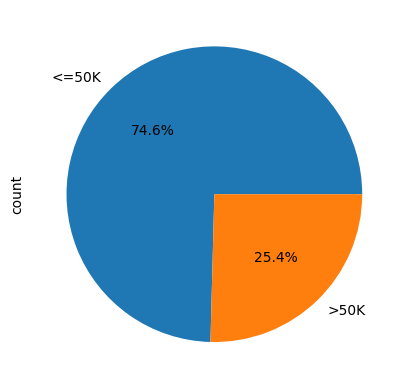

In [5]:
# Check the Balancing of the target variable

training_df[target_col].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [6]:
## Quick check of columns dtypes and unique values count to determine the encoding strategy
for col in training_df.columns:
    print(f"{training_df[col].name}: {training_df[col].dtype}, Unique values: {training_df[col].nunique()}")

age: int64, Unique values: 74
workclass: object, Unique values: 7
education_num: int64, Unique values: 16
marital_status: object, Unique values: 7
relationship: object, Unique values: 6
race: object, Unique values: 5
sex: object, Unique values: 2
capital_gain: int64, Unique values: 121
capital_loss: int64, Unique values: 97
hours_per_week: int64, Unique values: 96
income: object, Unique values: 2
occupation_grouped: object, Unique values: 8
native_country_grouped: object, Unique values: 4


In [7]:
from sklearn.preprocessing import LabelEncoder
X = training_df.drop(columns=[target_col])
y = training_df[target_col]

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Encode features 
# Only label encode truly categorical binary variables
label_encode_cols = ['sex']  
X_encoded = X.copy()
le_dict = {}

for col in label_encode_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        le_dict[col] = le

# One-hot encode remaining categorical columns (excluding numerical and already encoded)
categorical_cols = [col for col in X_encoded.columns 
                   if col not in numerical_columns and col not in label_encode_cols]

X_encoded = pd.get_dummies(X_encoded, columns=categorical_cols, drop_first=True)

print(f"Encoded data shape: {X_encoded.shape}")
print(f"Label encoded: {label_encode_cols}")
print(f"One-hot encoded: {categorical_cols}")

Encoded data shape: (39240, 37)
Label encoded: ['sex']
One-hot encoded: ['workclass', 'marital_status', 'relationship', 'race', 'occupation_grouped', 'native_country_grouped']


In [8]:
# quick check of the encoded DataFrame
X_encoded.head()

,age,education_num,sex,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,occupation_grouped_Craft-repair,occupation_grouped_Exec-managerial,occupation_grouped_Machine-op-inspct,occupation_grouped_Other,occupation_grouped_Other-service,occupation_grouped_Prof-specialty,occupation_grouped_Sales,native_country_grouped_Other,native_country_grouped_Philippines,native_country_grouped_United-States
0,39,13,1,2174,0,40,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
1,50,13,1,0,0,13,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True
2,38,9,1,0,0,40,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True
3,53,7,1,0,0,40,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
4,28,13,0,0,0,40,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False


In [9]:
# quick check of the encoded target
y_encoded

array([0, 0, 0, ..., 0, 0, 1], shape=(39240,))

### Creaste the train-test and validation splits (validation will help us understand model performance on unseen data). Train - 60%, test - 20% and validation- 20%

In [10]:
# Create train-validation-test split (60%-20%-20%)
from sklearn.model_selection import train_test_split

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Second split: divide remaining 80% into train (60% of total) and validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 80% = 20% of total
)

print("DATASET SPLITS:")
print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"Test set:       {len(X_test):,} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(X_encoded)*100:.1f}%)")
print(f"Total:          {len(X_encoded):,} samples")

print(f"\nCLASS DISTRIBUTIONS:")
print(f"Training:   {pd.Series(y_train).value_counts().sort_index().values}")
print(f"Test:       {pd.Series(y_test).value_counts().sort_index().values}")
print(f"Validation: {pd.Series(y_val).value_counts().sort_index().values}")

# Verify proportions are maintained
for split_name, y_split in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
    proportions = pd.Series(y_split).value_counts(normalize=True).sort_index()
    print(f"{split_name} proportions: {proportions.values}")

DATASET SPLITS:
Training set:   23,544 samples (60.0%)
Test set:       7,848 samples (20.0%)
Validation set: 7,848 samples (20.0%)
Total:          39,240 samples

CLASS DISTRIBUTIONS:
Training:   [17559  5985]
Test:       [5853 1995]
Validation: [5853 1995]
Training proportions: [0.74579511 0.25420489]
Validation proportions: [0.74579511 0.25420489]
Test proportions: [0.74579511 0.25420489]


In [11]:
# Apply SMOTE only to training set (validation and test remain original)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
print(f"Training set:   {pd.Series(y_train_balanced).value_counts().sort_index().values}")
print(f"Test set:       {pd.Series(y_test).value_counts().sort_index().values} (unchanged)")
print(f"Validation set: {pd.Series(y_val).value_counts().sort_index().values} (unchanged)")

After SMOTE:
Training set:   [17559 17559]
Test set:       [5853 1995] (unchanged)
Validation set: [5853 1995] (unchanged)


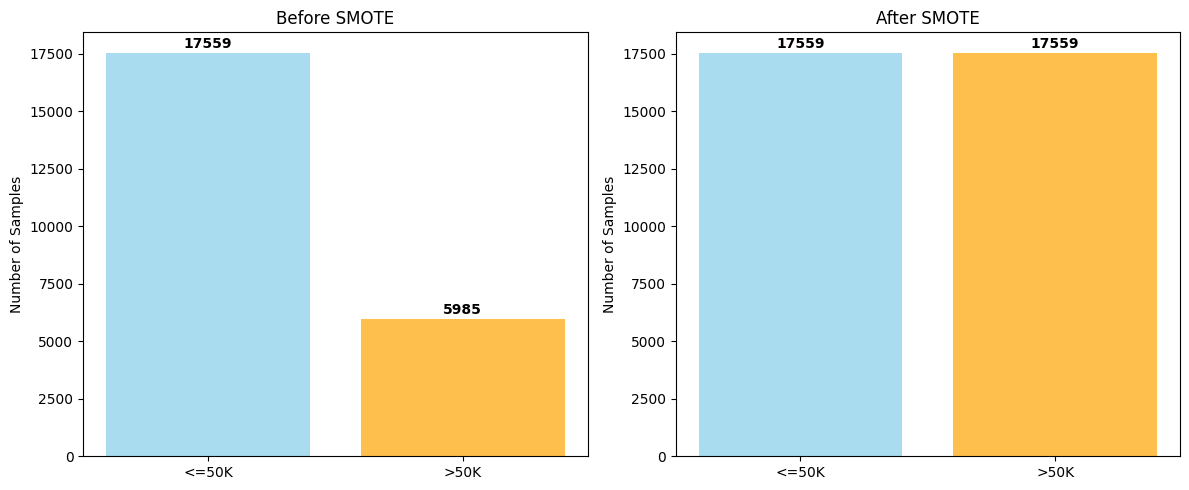

Original class distribution: [17559  5985]
After SMOTE class distribution: [17559 17559]
SMOTE added 11574 synthetic samples for >50K class


In [12]:
# Visualize SMOTE impact on class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get actual counts from the data
original_counts = pd.Series(y_train).value_counts().sort_index().values
smote_counts = pd.Series(y_train_balanced).value_counts().sort_index().values

# 1. Before SMOTE
axes[0].bar(['<=50K', '>50K'], original_counts, color=['skyblue', 'orange'], alpha=0.7)
axes[0].set_title('Before SMOTE')
axes[0].set_ylabel('Number of Samples')
for i, v in enumerate(original_counts):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# 2. After SMOTE
axes[1].bar(['<=50K', '>50K'], smote_counts, color=['skyblue', 'orange'], alpha=0.7)
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Number of Samples')
for i, v in enumerate(smote_counts):
    axes[1].text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Original class distribution: {original_counts}")
print(f"After SMOTE class distribution: {smote_counts}")
print(f"SMOTE added {smote_counts[1] - original_counts[1]} synthetic samples for >50K class")

In [13]:
# Train model with TEST SET monitoring (for tuning)
print("Training XGBoost with TEST SET monitoring for tuning...")

xgb_model = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'
)

# Fit with TEST SET monitoring (for hyperparameter tuning)
xgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_train_balanced, y_train_balanced), (X_test, y_test)],  # <- TEST SET for tuning
    verbose=False
)

# Evaluate on all three sets
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    
    print(f"\n{set_name} Results:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  AUC: {auc:.3f}")
    
    return y_pred, y_pred_proba, accuracy, f1, auc

# Evaluate on all sets
train_pred, train_proba, train_acc, train_f1, train_auc = evaluate_model(xgb_model, X_train_balanced, y_train_balanced, "TRAINING")
test_pred, test_proba, test_acc, test_f1, test_auc = evaluate_model(xgb_model, X_test, y_test, "TEST (TUNING)")
val_pred, val_proba, val_acc, val_f1, val_auc = evaluate_model(xgb_model, X_val, y_val, "VALIDATION (REAL-LIFE)")

# Check for overfitting
print(f"\nOVERFITTING ANALYSIS:")
print(f"Training vs Test AUC difference: {abs(train_auc - test_auc):.3f}")
print(f"Training vs Validation AUC difference: {abs(train_auc - val_auc):.3f}")

if abs(train_auc - test_auc) > 0.05:
    print("Possible overfitting detected (>5% AUC difference)")
elif abs(train_auc - test_auc) > 0.02:
    print("Mild overfitting (2-5% AUC difference)")
else:
    print("No significant overfitting detected")

print(f"\nMODEL WORKFLOW:")
print(f"1. Train on training set (with SMOTE)")
print(f"2. Monitor/tune using TEST set (seen during training)")
print(f"3. Final real-life evaluation on VALIDATION set (completely unseen)")
print(f"4. Validation performance = True generalization capability")

Training XGBoost with TEST SET monitoring for tuning...

TRAINING Results:
  Accuracy: 0.914
  F1-Score: 0.915
  AUC: 0.976

TEST (TUNING) Results:
  Accuracy: 0.848
  F1-Score: 0.716
  AUC: 0.915

VALIDATION (REAL-LIFE) Results:
  Accuracy: 0.845
  F1-Score: 0.710
  AUC: 0.915

OVERFITTING ANALYSIS:
Training vs Test AUC difference: 0.062
Training vs Validation AUC difference: 0.061
Possible overfitting detected (>5% AUC difference)

MODEL WORKFLOW:
1. Train on training set (with SMOTE)
2. Monitor/tune using TEST set (seen during training)
3. Final real-life evaluation on VALIDATION set (completely unseen)
4. Validation performance = True generalization capability


In [14]:
# Add confusion matrix analysis
from sklearn.metrics import classification_report

print("\nCONFUSION MATRICES:")

for name, y_true, y_pred in [("Training", y_train_balanced, train_pred),
                            ("Test (Tuning)", y_test, test_pred), 
                            ("Validation (Real-life)", y_val, val_pred)]:
    
    print(f"\n{name}:")
    print(classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))


CONFUSION MATRICES:

Training:
              precision    recall  f1-score   support

       <=50K       0.93      0.90      0.91     17559
        >50K       0.90      0.93      0.92     17559

    accuracy                           0.91     35118
   macro avg       0.91      0.91      0.91     35118
weighted avg       0.91      0.91      0.91     35118


Test (Tuning):
              precision    recall  f1-score   support

       <=50K       0.91      0.88      0.90      5853
        >50K       0.68      0.76      0.72      1995

    accuracy                           0.85      7848
   macro avg       0.80      0.82      0.81      7848
weighted avg       0.85      0.85      0.85      7848


Validation (Real-life):
              precision    recall  f1-score   support

       <=50K       0.91      0.88      0.89      5853
        >50K       0.68      0.74      0.71      1995

    accuracy                           0.85      7848
   macro avg       0.79      0.81      0.80      7848
w

In [16]:
from sklearn.metrics import confusion_matrix
# Train model WITHOUT SMOTE for comparison
print("Training XGBoost WITHOUT SMOTE for comparison...")

xgb_model_no_smote = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'
)

# Train on original imbalanced training set
xgb_model_no_smote.fit(
    X_train, y_train,  # Original imbalanced data
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Evaluate WITHOUT SMOTE
train_pred_ns, train_proba_ns, train_acc_ns, train_f1_ns, train_auc_ns = evaluate_model(xgb_model_no_smote, X_train, y_train, "TRAINING (NO SMOTE)")
test_pred_ns, test_proba_ns, test_acc_ns, test_f1_ns, test_auc_ns = evaluate_model(xgb_model_no_smote, X_test, y_test, "TEST (NO SMOTE)")
val_pred_ns, val_proba_ns, val_acc_ns, val_f1_ns, val_auc_ns = evaluate_model(xgb_model_no_smote, X_val, y_val, "VALIDATION (NO SMOTE)")

# Performance comparison table
comparison_df = pd.DataFrame({
    'Model': ['With SMOTE', 'Without SMOTE'],
    'Val_Accuracy': [val_acc, val_acc_ns],
    'Val_F1': [val_f1, val_f1_ns],
    'Val_AUC': [val_auc, val_auc_ns],
    'Val_Precision': [1523/(1523+743), val_pred_ns[val_pred_ns==1].sum()/(val_pred_ns[val_pred_ns==1].sum() + ((val_pred_ns==1) & (y_val==0)).sum())],
    'Val_Recall': [1523/(1523+472), val_pred_ns[val_pred_ns==1].sum()/(val_pred_ns[val_pred_ns==1].sum() + ((val_pred_ns==0) & (y_val==1)).sum())]
})

print("\nVALIDATION PERFORMANCE COMPARISON:")
print(comparison_df.round(3))

Training XGBoost WITHOUT SMOTE for comparison...

TRAINING (NO SMOTE) Results:
  Accuracy: 0.889
  F1-Score: 0.769
  AUC: 0.953

TEST (NO SMOTE) Results:
  Accuracy: 0.862
  F1-Score: 0.709
  AUC: 0.923

VALIDATION (NO SMOTE) Results:
  Accuracy: 0.861
  F1-Score: 0.707
  AUC: 0.924

VALIDATION PERFORMANCE COMPARISON:
           Model  Val_Accuracy  Val_F1  Val_AUC  Val_Precision  Val_Recall
0     With SMOTE         0.845   0.710    0.915          0.672       0.763
1  Without SMOTE         0.861   0.707    0.924          0.808       0.717


### Conclusion - Ballancing is not needed as we are obtaining more stable results without it in both test and validation sets.

In [17]:
# Hyperparameter optimization for XGBoost (Fixed)
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("Starting Hyperparameter Optimization...")

# Define parameter grid
param_grid = {
    # Regularization parameters
    'reg_alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'reg_lambda': [0.1, 0.5, 1.0, 2.0, 5.0],
    
    # Tree structure
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.5, 1.0, 2.0],
    
    # Learning parameters
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 500],
    
    # Sampling parameters
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Create base model WITHOUT early_stopping_rounds for RandomizedSearchCV
xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
    # Remove early_stopping_rounds for cross-validation
)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation AUC score: {random_search.best_score_:.4f}")

Starting Hyperparameter Optimization...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:
  subsample: 1.0
  reg_lambda: 0.5
  reg_alpha: 1.0
  n_estimators: 500
  min_child_weight: 5
  max_depth: 4
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 0.7

Best cross-validation AUC score: 0.9229


In [18]:
# Train the optimized model with the best parameters
print("Training optimized XGBoost model...")

# Create optimized model with best parameters + early stopping
xgb_optimized = XGBClassifier(
    **random_search.best_params_,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20  # Add back early stopping for final training
)

# Train with validation monitoring
xgb_optimized.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

print(f"Best iteration: {xgb_optimized.best_iteration}")
print(f"Best score: {xgb_optimized.best_score:.4f}")

Training optimized XGBoost model...
Best iteration: 499
Best score: 0.2864


In [19]:
# Evaluate optimized model
train_pred_opt, train_proba_opt, train_acc_opt, train_f1_opt, train_auc_opt = evaluate_model(xgb_optimized, X_train, y_train, "TRAINING (OPTIMIZED)")
test_pred_opt, test_proba_opt, test_acc_opt, test_f1_opt, test_auc_opt = evaluate_model(xgb_optimized, X_test, y_test, "TEST (OPTIMIZED)")
val_pred_opt, val_proba_opt, val_acc_opt, val_f1_opt, val_auc_opt = evaluate_model(xgb_optimized, X_val, y_val, "VALIDATION (OPTIMIZED)")

print("\nOptimized XGBoost Model Performance:")
print(f"Training   - Acc: {train_acc_opt:.3f}, F1: {train_f1_opt:.3f}, AUC: {train_auc_opt:.3f}")
print(f"Test       - Acc: {test_acc_opt:.3f}, F1: {test_f1_opt:.3f}, AUC: {test_auc_opt:.3f}")
print(f"Validation - Acc: {val_acc_opt:.3f}, F1: {val_f1_opt:.3f}, AUC: {val_auc_opt:.3f}")


TRAINING (OPTIMIZED) Results:
  Accuracy: 0.871
  F1-Score: 0.725
  AUC: 0.934

TEST (OPTIMIZED) Results:
  Accuracy: 0.865
  F1-Score: 0.711
  AUC: 0.924

VALIDATION (OPTIMIZED) Results:
  Accuracy: 0.864
  F1-Score: 0.708
  AUC: 0.926

Optimized XGBoost Model Performance:
Training   - Acc: 0.871, F1: 0.725, AUC: 0.934
Test       - Acc: 0.865, F1: 0.711, AUC: 0.924
Validation - Acc: 0.864, F1: 0.708, AUC: 0.926


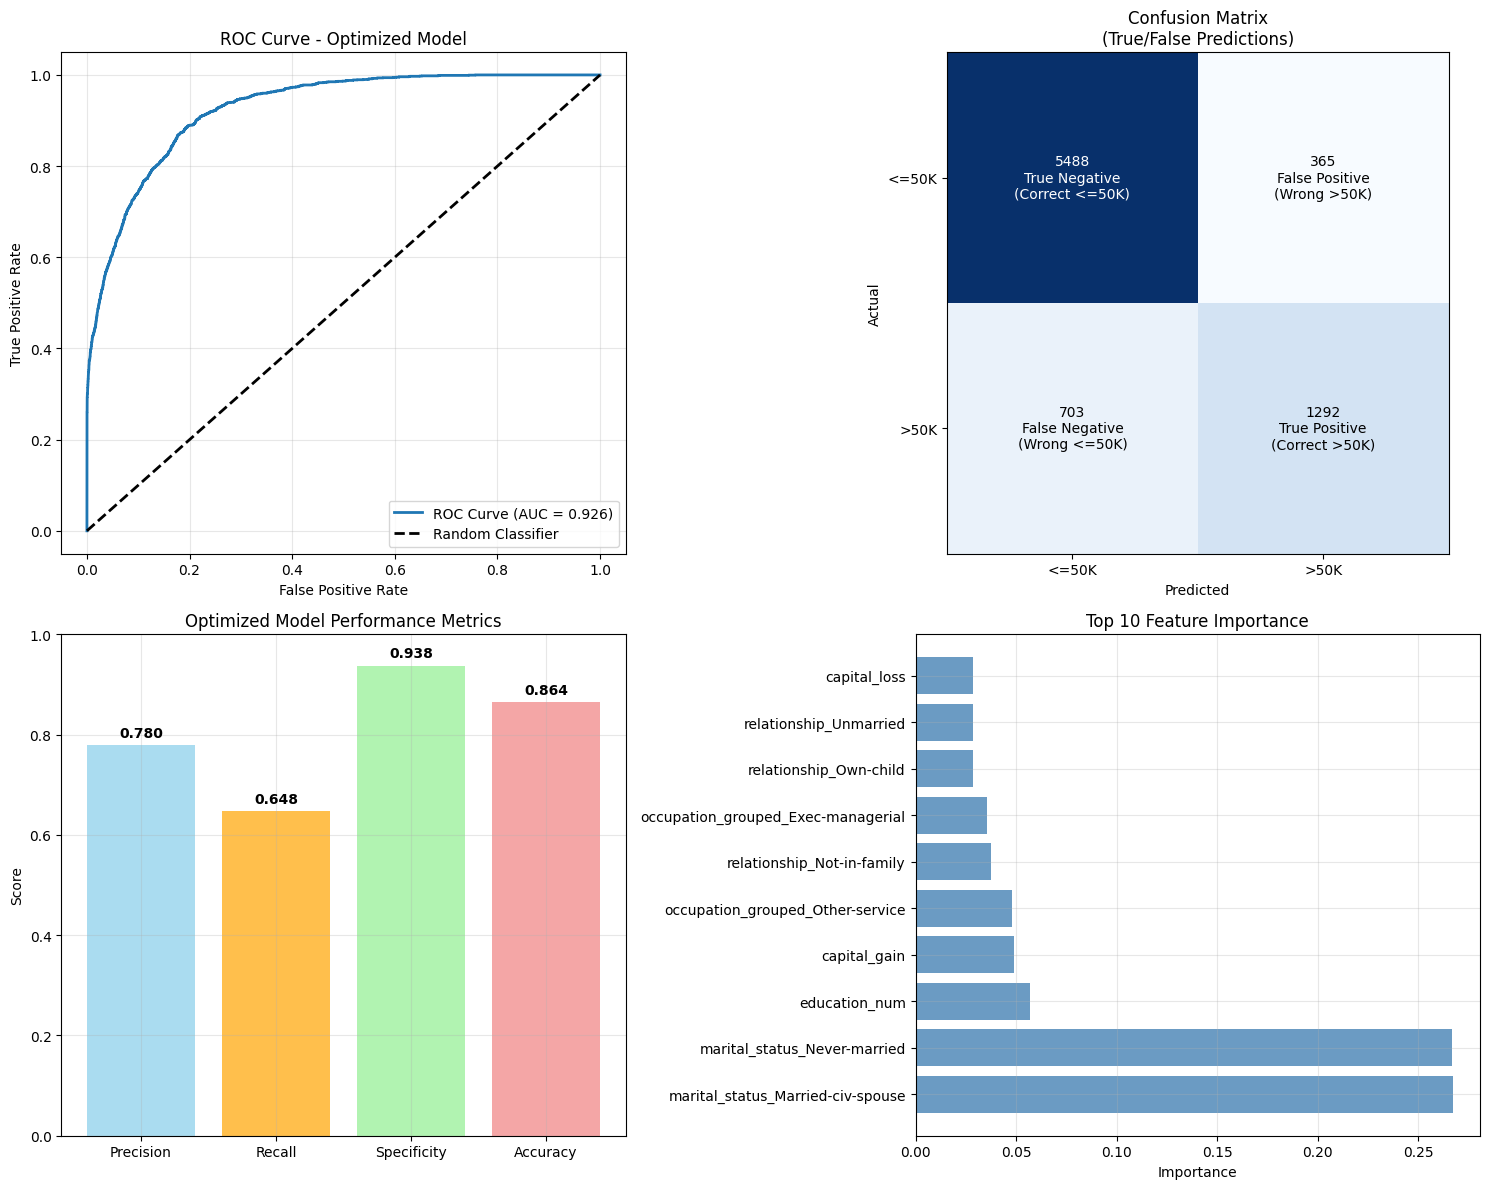

In [20]:
# Advanced visualizations: ROC curve, AUC, and detailed performance
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_val, val_proba_opt)
auc_score = roc_auc_score(y_val, val_proba_opt)

axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Optimized Model')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix with True/False labels
cm = confusion_matrix(y_val, val_pred_opt)
im = axes[0, 1].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0, 1].set_title('Confusion Matrix\n(True/False Predictions)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Add detailed annotations
labels = [['True Negative\n(Correct <=50K)', 'False Positive\n(Wrong >50K)'],
          ['False Negative\n(Wrong <=50K)', 'True Positive\n(Correct >50K)']]

for i in range(2):
    for j in range(2):
        axes[0, 1].text(j, i, f'{cm[i, j]}\n{labels[i][j]}',
                       ha="center", va="center", fontsize=10,
                       color="white" if cm[i, j] > cm.max() / 2. else "black")

axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['<=50K', '>50K'])
axes[0, 1].set_yticklabels(['<=50K', '>50K'])

# 3. Performance metrics comparison
precision = precision_score(y_val, val_pred_opt)
recall = recall_score(y_val, val_pred_opt)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate

metrics = ['Precision', 'Recall', 'Specificity', 'Accuracy']
values = [precision, recall, specificity, val_acc_opt]
colors = ['skyblue', 'orange', 'lightgreen', 'lightcoral']

bars = axes[1, 0].bar(metrics, values, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Optimized Model Performance Metrics')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Feature importance
feature_importance = xgb_optimized.feature_importances_
feature_names = X_train.columns
top_features = sorted(zip(feature_importance, feature_names), reverse=True)[:10]
top_importance, top_names = zip(*top_features)

axes[1, 1].barh(range(len(top_names)), top_importance, alpha=0.8, color='steelblue')
axes[1, 1].set_yticks(range(len(top_names)))
axes[1, 1].set_yticklabels(top_names)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Performance summary with True/False breakdown
print("\nDETAILED PERFORMANCE BREAKDOWN:")
print("="*50)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correctly predicted <=50K):  {tn:,}")
print(f"False Positives (Incorrectly predicted >50K): {fp:,}")
print(f"False Negatives (Incorrectly predicted <=50K): {fn:,}")
print(f"True Positives (Correctly predicted >50K):   {tp:,}")

print(f"\nACCURACY BREAKDOWN:")
print(f"Overall Accuracy: {val_acc_opt:.3f}")
print(f"Precision (>50K): {precision:.3f}")
print(f"Recall (>50K):    {recall:.3f}")
print(f"Specificity (<=50K): {specificity:.3f}")
print(f"AUC Score:        {auc_score:.3f}")

print(f"\nOPTIMIZATION RESULTS:")
print(f"Best CV AUC:      {random_search.best_score_:.3f}")
print(f"Final Val AUC:    {val_auc_opt:.3f}")
print(f"Improvement:      {val_auc_opt - val_auc_ns:.3f} vs No SMOTE")


DETAILED PERFORMANCE BREAKDOWN:
True Negatives (Correctly predicted <=50K):  5,488
False Positives (Incorrectly predicted >50K): 365
False Negatives (Incorrectly predicted <=50K): 703
True Positives (Correctly predicted >50K):   1,292

ACCURACY BREAKDOWN:
Overall Accuracy: 0.864
Precision (>50K): 0.780
Recall (>50K):    0.648
Specificity (<=50K): 0.938
AUC Score:        0.926

OPTIMIZATION RESULTS:
Best CV AUC:      0.923
Final Val AUC:    0.926
Improvement:      0.002 vs No SMOTE


In [22]:
# FINAL PRODUCTION MODEL: Train on ALL data
print("Training FINAL PRODUCTION MODEL on complete dataset...")
print("="*60)

# Use ALL available data for training (100% of dataset)
X_final_train = X_encoded  # All encoded data
y_final_train = y_encoded  # All encoded targets

print(f"Training on complete dataset: {len(X_final_train):,} samples (100%)")
print(f"Features: {X_final_train.shape[1]}")

# Train final model with optimized parameters on ALL data
final_model = XGBClassifier(
    **random_search.best_params_,
    random_state=42,
    eval_metric='logloss'
    # No early_stopping_rounds - training on all data
    # No eval_set - no validation monitoring
)

# Simple training on complete dataset
print(f"\nTraining with optimized hyperparameters...")
final_model.fit(X_final_train, y_final_train)

print("PRODUCTION MODEL TRAINED SUCCESSFULLY!")
print(f"Model uses {final_model.n_estimators} estimators")
print(f"Trained on {len(X_final_train):,} samples (100% of available data)")

Training FINAL PRODUCTION MODEL on complete dataset...
Training on complete dataset: 39,240 samples (100%)
Features: 37

Training with optimized hyperparameters...
PRODUCTION MODEL TRAINED SUCCESSFULLY!
Model uses 500 estimators
Trained on 39,240 samples (100% of available data)


In [25]:
import pickle
import joblib
import os
import json
from pathlib import Path

print("\nSAVING FINAL PRODUCTION MODEL...")
print("="*50)

# Use project root as the base directory (portable for all users)
project_root = Path().resolve().parent.parent  # Adjust as needed if running from subfolders
models_path = project_root / 'models'
models_path.mkdir(exist_ok=True)

# Save the production model
joblib.dump(final_model, models_path / 'production_model.pkl')

# Save all preprocessing components
with open(models_path / 'preprocessing_components.pkl', 'wb') as f:
    pickle.dump({
        'target_encoder': le_target,
        'feature_encoders': le_dict,
        'feature_columns': list(X_final_train.columns),
        'categorical_columns': categorical_columns,
        'numerical_columns': numerical_columns
    }, f)

# Save model metadata
production_metadata = {
    'model_type': 'XGBoost Classifier - Production',
    'training_approach': 'Complete dataset training (100%)',
    'hyperparameters': random_search.best_params_,
    'training_data': {
        'total_samples': int(len(X_final_train)),
        'num_features': int(X_final_train.shape[1]),
        'class_distribution': pd.Series(y_final_train).value_counts().to_dict()
    },
    'expected_performance': {
        'estimated_auc': float(val_auc_opt),
        'note': 'Performance estimate from hyperparameter optimization phase'
    },
    'deployment_info': {
        'ready_for_production': True,
        'trained_on_complete_data': True,
        'maximum_data_utilization': True
    }
}

with open(models_path / 'production_metadata.json', 'w') as f:
    json.dump(production_metadata, f, indent=2)

print("PRODUCTION MODEL SAVED!")
print("="*40)
print(f"Model file: {models_path / 'production_model.pkl'}")
print(f"Preprocessing: {models_path / 'preprocessing_components.pkl'}")
print(f"Metadata: {models_path / 'production_metadata.json'}")
print(f"Trained on: {len(X_final_train):,} samples (100% of data)")
print(f"Expected AUC: {val_auc_opt:.4f} (from hyperparameter tuning)")
print("Ready for deployment!")

print(f"\nMODEL SUMMARY:")
print(f"• Uses optimized hyperparameters from RandomizedSearchCV")
print(f"• Trained on maximum available data")
print(f"• Production-ready for real-world deployment")


SAVING FINAL PRODUCTION MODEL...
PRODUCTION MODEL SAVED!
Model file: C:\Users\jarie\OneDrive\Escritorio\VsCode\models\production_model.pkl
Preprocessing: C:\Users\jarie\OneDrive\Escritorio\VsCode\models\preprocessing_components.pkl
Metadata: C:\Users\jarie\OneDrive\Escritorio\VsCode\models\production_metadata.json
Trained on: 39,240 samples (100% of data)
Expected AUC: 0.9261 (from hyperparameter tuning)
Ready for deployment!

MODEL SUMMARY:
• Uses optimized hyperparameters from RandomizedSearchCV
• Trained on maximum available data
• Production-ready for real-world deployment
